In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
data = pd.read_csv("train.csv")
print(data.shape)
data.head()

(19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Three authors:
1. EAP (Edgar Allen Poe)
2. HPL (HP Lovecraft)
3. MWS (Mary Shelly)

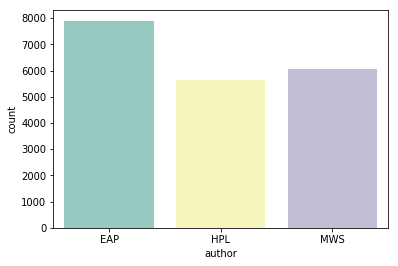

In [4]:
sns.countplot(x=data.author, palette="Set3")

### WordColouds

In [5]:
eap = data[data.author=="EAP"]["text"].values
hpl = data[data.author=="HPL"]["text"].values
mws = data[data.author=="MWS"]["text"].values

In [6]:
from scipy.misc import imread
hcmask = imread("eap.png")
hcmask2 = imread("mws.png")
hcmask3 = imread("hpl.png")

(-0.5, 511.5, 511.5, -0.5)

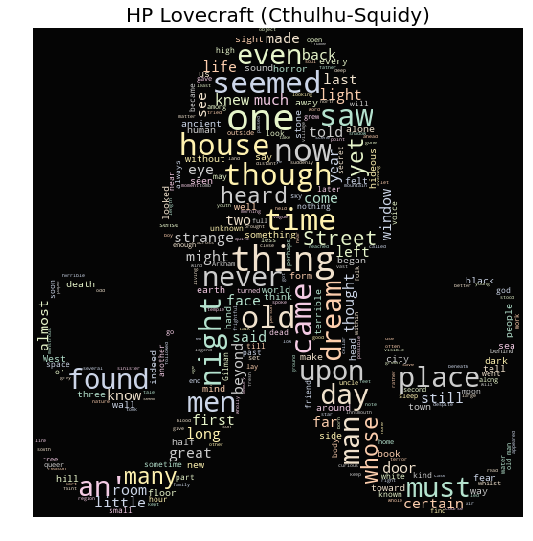

In [7]:
plt.figure(figsize=(12,9))
wc = WordCloud(background_color="black", max_words=10000, 
               mask=hcmask3, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 639.5, 390.5, -0.5)

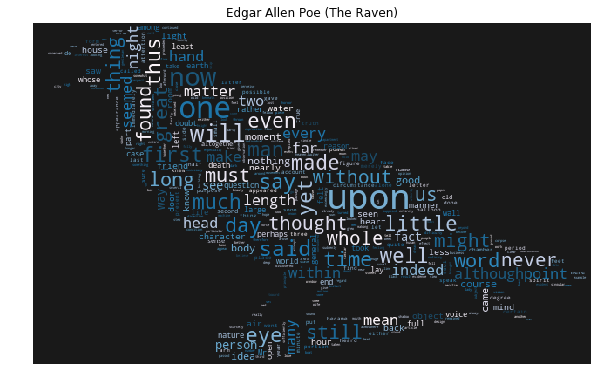

In [8]:
plt.figure(figsize=(10,9))
wc = WordCloud(background_color="black", max_words=10000, mask=hcmask, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 639.5, 589.5, -0.5)

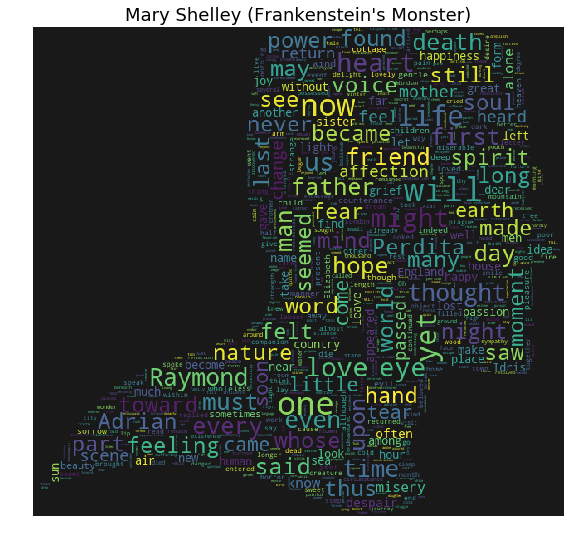

In [9]:
plt.figure(figsize=(12,9))
wc = WordCloud(background_color="black", max_words=10000,  mask=hcmask2,  stopwords=STOPWORDS,  max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

## Preprocessing

In [10]:
import spacy
import nltk

In [11]:
from spacy.lang.en import English
nlp = English()

In [12]:
from spacy.lang.en import STOP_WORDS
STOP_WORDS.add("''s'")

In [13]:
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [14]:
def replace_ents(doc):
    prefix = 'ent__'
    text = str(doc.doc)
    for ent in doc.ents:
        text = text.replace(ent.orth_, prefix + ent.label_)
    return text

In [15]:
def preprocess(df):
    df['text'] = [t.lower() for t in df.text]
    print('Started parsing...')
    doc = df.text.apply(nlp)
    print('Text parsed')
    
    df['n_char']   = df.text.apply(len)
    df['n_words']  = doc.apply(lambda x: len([t for t in x if not t.is_punct]))
    df['n_punct']  = doc.apply(lambda x: len([t for t in x if t.is_punct]))
    df['n_ents']   = doc.apply(lambda x: len(x.ents))
    df['n_unique_words'] = doc.apply(lambda x: len(set([t.lower_ for t in x if not t.is_punct])))
    df['n_stop_words']   = doc.apply(lambda x: len([t for t in x if t.is_stop]))
    df['char_by_word']   = doc.apply(lambda x: np.mean([len(t.orth_) for t in x if not t.is_punct]))
    print('Features created')
    
    df['text_ent_repl'] = doc.apply(replace_ents)
    print('Entities replaced')
    
    clean_and_lemmatize = lambda x: ' '.join([t.lemma_ for t in x if not t.is_punct and not t.is_stop])
    df['text_cleaned'] = doc.apply(clean_and_lemmatize)
    print('Text cleaned')

In [16]:
preprocess(data)

Started parsing...
Text parsed
Features created
Entities replaced
Text cleaned


In [17]:
data.head()

,id,text,author,n_char,n_words,n_punct,n_ents,n_unique_words,n_stop_words,char_by_word,text_ent_repl,text_cleaned
0,id26305,"this process, however, afforded me no means of...",EAP,231,41,7,0,35,26,4.487805,"this process, however, afforded me no means of...",process afford mean ascertain dimension dungeo...
1,id17569,it never once occurred to me that the fumbling...,HPL,71,14,1,0,14,10,4.071429,it never once occurred to me that the fumbling...,occur fumble mere mistake
2,id11008,"in his left hand was a gold snuff box, from wh...",EAP,200,36,5,0,32,17,4.444444,"in his left hand was a gold snuff box, from wh...",leave hand gold snuff box caper hill cut manne...
3,id27763,how lovely is spring as we looked from windsor...,MWS,206,34,4,0,31,14,4.970588,how lovely is spring as we looked from windsor...,lovely spring look windsor terrace sixteen fer...
4,id12958,"finding nothing else, not even gold, the super...",HPL,174,27,4,0,25,14,5.333333,"finding nothing else, not even gold, the super...",find gold superintendent abandon attempt perpl...


In [18]:
eap = data.loc[data.author == 'EAP']
hpl = data.loc[data.author == 'HPL']
mws = data.loc[data.author == 'MWS']

all_t = [y for x in data.text_cleaned.str.split() for y in x]
eap_t = [y for x in eap.text_cleaned.str.split() for y in x]
hpl_t = [y for x in hpl.text_cleaned.str.split() for y in x]
mws_t = [y for x in mws.text_cleaned.str.split() for y in x]
all_t = [a for a in all_t if not a=='have']
eap_t = [a for a in eap_t if not a=='have']
hpl_t = [a for a in hpl_t if not a=='have']
mws_t = [a for a in mws_t if not a=='have']

In [19]:
fd = nltk.FreqDist(all_t)
fd_eap = nltk.FreqDist(eap_t)
fd_hpl = nltk.FreqDist(hpl_t)
fd_mws = nltk.FreqDist(mws_t)

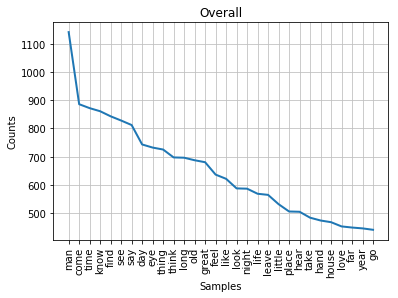

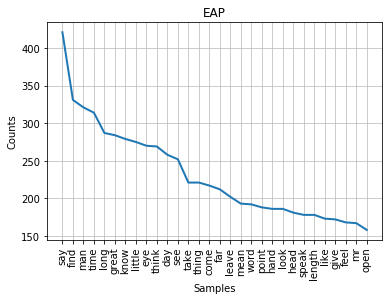

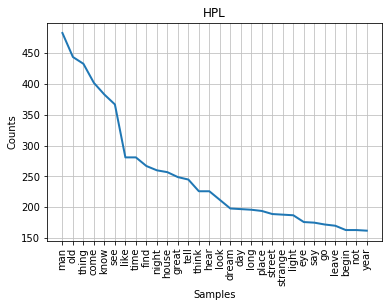

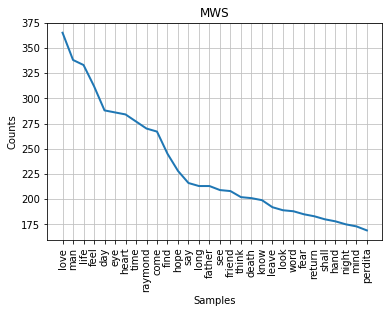

In [20]:
fd.plot(30, title='Overall')
fd_eap.plot(30, title='EAP')
fd_hpl.plot(30, title='HPL')
fd_mws.plot(30, title='MWS')

In [21]:
def drop_outliers(s):
    med = s.mean()
    std = s.std()
    return s[(med - 3*std <= s) & (s <= med + 3*std)]

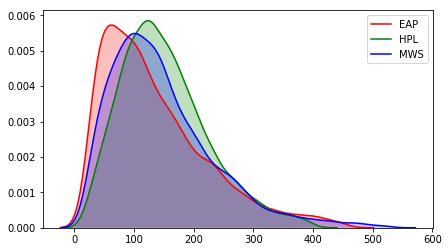

In [22]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_char), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_char), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_char), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);

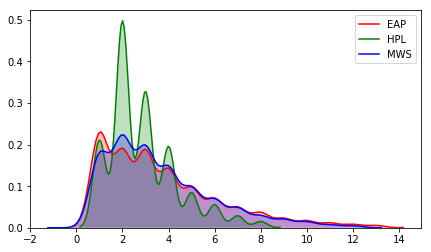

In [23]:
f, ax = plt.subplots(figsize=(7,4))
sns.kdeplot(drop_outliers(eap.n_punct), shade=True, color="r");
sns.kdeplot(drop_outliers(hpl.n_punct), shade=True, color="g");
sns.kdeplot(drop_outliers(mws.n_punct), shade=True, color="b");
ax.legend(labels=['EAP', 'HPL', 'MWS']);